# 01 Data Preparation

The purpose of this notebook lies in the preprocessing, cleaning, and preparation of the taxi trips and the weather datasets for the city of Chicago in the year 2013. The datasets are then to be used to gain insights into the spatio-temporal taxi demand patterns in Chicago.

* Trips Dataset
    * Preprocessing
    * Imports
    * Cleaning
    * H3-Uber
    * Preparation

* Weather Dataset
    * Cleaning Kaggle (OpenWeather) Datasets
        * Temperature
        * Weather Description
        * Humidity
        * Wind Speed
        * Pressure
    * Merging Kaggle Data
    * Creating Additional Weather Datasets
        * 4-Hourly
        * Daily

# Trips Dataset

## Preprocessing

Due to the original taxi trips dataset's large size (>10 GB), we utilize the data preprocessing tool csvkit (https://csvkit.readthedocs.io/en/latest/) to remove unwanted rows in the dataset. We use those commands that decrease the dataset's size the most while also not deleting rows that are needed for the tasks.

@Justus --> mehr Infos zu Befehlen etc.

prepro.csv - „Trip Seconds“ and „Trip Miles“ = 0 (25.978.472)

prepro2.csv - „Pickup Centroid Latitude“ = Null (21.849.007)

prepro3.csv - „Dropoff Centroid Latitude“ = Null (21.065.248)

prepro4.csv - „Pickup Census Tract“ = Null (15.511.065)

prepro5.csv - „Trip Seconds“ = Null (15.509.724)

10,83 GB -> 6,66 GB

## Imports

In [1]:
# Import libraries needed for data preparation
import numpy as np
import pandas as pd
import datetime
import pickle
import pandas as pd
import h3
import json
import geopandas as gpd
from shapely.geometry import shape
import math
import warnings
warnings.filterwarnings('ignore')

## Cleaning 

Now, we load the preprocessed dataframe for the cleaning and preparation step.

In [2]:
# Load dataframe
df_trips = pd.read_csv("taxi_trips_2013.csv")
print("Number of rows:    ", len(df_trips))
print("Number of columns: ", len(df_trips.columns))
df_trips.head(5)

Number of rows:     15511065
Number of columns:  23


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,5017af8a3fc0962306727ca31e6a7f6378a42df3,18f4d1898ead14ae8bc4828a02ead3e6c6294429ebf347...,09/23/2013 02:45:00 AM,01/13/2015 10:45:00 AM,NaN,0.0,17031980100,17031980100,56.0,56.0,...,0.0,3.65,Cash,Taxi Affiliation Services,41.785999,-87.750934,POINT (-87.7509342894 41.785998518),41.785999,-87.750934,POINT (-87.7509342894 41.785998518)
1,20c265b0165f4d6da795517f8df28683af632bed,18f4d1898ead14ae8bc4828a02ead3e6c6294429ebf347...,09/23/2013 02:45:00 AM,09/23/2013 02:45:00 AM,60.0,0.0,17031842300,17031832300,24.0,22.0,...,0.0,3.45,Cash,Taxi Affiliation Services,41.898306,-87.653614,POINT (-87.6536139825 41.8983058696),41.919225,-87.671446,POINT (-87.671445766 41.9192250505)
2,cacd06d1dcf908ad1334db68ecf3007ada7b4504,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/10/2013 11:45:00 PM,12/23/2014 02:30:00 PM,NaN,0.0,17031839000,17031980100,32.0,56.0,...,3.0,28.85,Cash,Dispatch Taxi Affiliation,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.785999,-87.750934,POINT (-87.7509342894 41.785998518)
3,f36b0ff47835ccba1d1835ad9f3fe0c809b46076,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/01/2014 03:00:00 PM,NaN,17.7,17031980000,17031839100,76.0,32.0,...,2.0,46.10,Credit Card,Dispatch Taxi Affiliation,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
4,d9c9335742e48cb845bbc05089145cf9b8b0c3cc,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:30:00 AM,1380.0,18.6,17031980000,17031320600,76.0,32.0,...,2.0,39.05,Cash,Dispatch Taxi Affiliation,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724)


In order to fulfill later tasks, we require all our rows to contain useful general information related to the trips, as well as complete spatial information. <br>
Therefore, we exclude rows that contain Null values in the following columns:

* Trip ID
* Taxi ID
* Trip Start Timestamp	
* Trip End Timestamp
* Trip Seconds
* Trip Miles
* Pickup Census Tract
* Dropoff Census Tract
* Pickup Centroid Latitude
* Pickup Centroid Longitude
* Pickup Centroid Location
* Dropoff Centroid Latitude
* Dropoff Centroid Longitude
* Dropoff Centroid Location



In addition, we want the values for Trip Seconds and Trip Miles to be bigger than 0 to exclude faulty trips.
<br>
We also drop the columns related to the community areas, since the community areas are not relevant for our task. 
<br> 
We keep the financially relevant information about the trip (i.e. Fare, Company, Payment Type, etc.) for the market analysis.

In [3]:
# Remove rows with Null values
# Two spaces between Centroid and Location at Dropoff
df_trips = df_trips.dropna(subset=['Trip ID', 'Taxi ID','Trip Start Timestamp','Trip End Timestamp',
                                   'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
                                  'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location',
                                  'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location' ])

# Remove rows with 0 values
df_trips = df_trips[(df_trips[['Trip Seconds','Trip Miles']] > 0).all(axis=1)]

# Drop columns
df_trips = df_trips.drop(['Pickup Community Area', 'Dropoff Community Area'], axis=1)

# Remove duplicated rows
df_trips.duplicated(keep='first')


4           False
5           False
7           False
8           False
11          False
            ...  
15511055    False
15511060    False
15511062    False
15511063    False
15511064    False
Length: 9001254, dtype: bool

Now, we inspect some information about the dataset.

In [4]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9001254 entries, 4 to 15511064
Data columns (total 21 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip End Timestamp          object 
 4   Trip Seconds                float64
 5   Trip Miles                  float64
 6   Pickup Census Tract         int64  
 7   Dropoff Census Tract        int64  
 8   Fare                        float64
 9   Tips                        float64
 10  Tolls                       float64
 11  Extras                      float64
 12  Trip Total                  float64
 13  Payment Type                object 
 14  Company                     object 
 15  Pickup Centroid Latitude    float64
 16  Pickup Centroid Longitude   float64
 17  Pickup Centroid Location    object 
 18  Dropoff Centroid Latitude   float64
 19  Dropoff Centroid Longitud

We can see that Trip Start Timestamp and Trip End Timestamp do not contain datetime objects that are necessary to perform temporal tasks. We will deal with this later.

In [5]:
df_trips.describe()

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,9.001254e+06,9.001254e+06,9.001254e+06,9.001254e+06,9.001114e+06,9.001114e+06,8.782142e+06,9.001114e+06,9.001114e+06,9.001254e+06,9.001254e+06,9.001254e+06,9.001254e+06
mean,7.398816e+02,3.428969e+00,1.703133e+10,1.703134e+10,1.180683e+01,8.803742e-01,1.051691e-02,7.855252e-01,1.348306e+01,4.189863e+01,-8.764878e+01,4.189862e+01,-8.764872e+01
std,9.980537e+02,1.138693e+01,3.299617e+05,3.298238e+05,6.974657e+01,1.962540e+00,8.228913e-01,1.751540e+01,7.266979e+01,3.000346e-02,6.003522e-02,3.111677e-02,5.622750e-02
min,1.000000e+00,1.000000e-02,1.703101e+10,1.703101e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.170328e+01,-8.790304e+01,4.165192e+01,-8.790304e+01
25%,3.600000e+02,6.000000e-01,1.703108e+10,1.703108e+10,5.850000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.650000e+00,4.188099e+01,-8.764281e+01,4.188099e+01,-8.764629e+01
50%,5.400000e+02,1.300000e+00,1.703108e+10,1.703124e+10,7.650000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.650000e+00,4.189207e+01,-8.763275e+01,4.189207e+01,-8.763275e+01
75%,8.400000e+02,2.600000e+00,1.703183e+10,1.703183e+10,1.105000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.245000e+01,4.190586e+01,-8.762621e+01,4.190749e+01,-8.762621e+01
max,8.622000e+04,1.995300e+03,1.703198e+10,1.703198e+10,9.725850e+03,4.447400e+02,8.337200e+02,9.142320e+03,9.757160e+03,4.202122e+01,-8.755199e+01,4.202122e+01,-8.753992e+01


Here, we check for consistency within the columns as regards data types:

In [6]:
# Check each column for consistency
for column in df_trips.columns:
    unique_types = df_trips[column].apply(type).unique()
    
    if len(unique_types) > 1:
        print(f"Column '{column}' has mixed data types: {unique_types}")
    else:
        print(f"Column '{column}' has consistent data type: {unique_types[0]}")


Column 'Trip ID' has consistent data type: <class 'str'>
Column 'Taxi ID' has consistent data type: <class 'str'>
Column 'Trip Start Timestamp' has consistent data type: <class 'str'>
Column 'Trip End Timestamp' has consistent data type: <class 'str'>
Column 'Trip Seconds' has consistent data type: <class 'float'>
Column 'Trip Miles' has consistent data type: <class 'float'>
Column 'Pickup Census Tract' has consistent data type: <class 'int'>
Column 'Dropoff Census Tract' has consistent data type: <class 'int'>
Column 'Fare' has consistent data type: <class 'float'>
Column 'Tips' has consistent data type: <class 'float'>
Column 'Tolls' has consistent data type: <class 'float'>
Column 'Extras' has consistent data type: <class 'float'>
Column 'Trip Total' has consistent data type: <class 'float'>
Column 'Payment Type' has consistent data type: <class 'str'>
Column 'Company' has mixed data types: [<class 'str'> <class 'float'>]
Column 'Pickup Centroid Latitude' has consistent data type: <

Since all mission-critical columns contain consistent data types, we can move on.

To further clean the dataset, we need to remove rows that contain faulty or unusual values in the Trip Seconds and Trip Miles columns. Trip distance is given in miles which is harder to interpret for the target audience (German car manufacturer). Thus, we convert it to kilometers.

In [7]:
## Convert from miles to kilometers
df_trips['Trip Miles'] = df_trips['Trip Miles'] * 1.609344
df_trips.rename(columns={"Trip Miles": "Trip Kilometers"}, inplace = True)
df_trips.head(5)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Kilometers,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
4,d9c9335742e48cb845bbc05089145cf9b8b0c3cc,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:30:00 AM,1380.0,29.933798,17031980000,17031320600,37.05,0.0,...,2.0,39.05,Cash,Dispatch Taxi Affiliation,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724)
5,e3477767844072c9c81948ce097ef5f85662c926,18f4d1898ead14ae8bc4828a02ead3e6c6294429ebf347...,09/23/2013 04:45:00 AM,09/23/2013 05:15:00 AM,2460.0,28.807258,17031320100,17031980000,38.05,5.0,...,2.0,45.05,Credit Card,Taxi Affiliation Services,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.979071,-87.903040,POINT (-87.9030396611 41.9790708201)
7,2d950cf31e72b549541b77b27776c4c2869d7cbb,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:00:00 AM,240.0,1.126541,17031081500,17031320100,5.05,0.0,...,0.0,5.05,Cash,Dispatch Taxi Affiliation,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
8,de85b0693d7e87ef291a4c68f95cbf0901629ada,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:15:00 AM,300.0,1.287475,17031320100,17031081800,5.45,0.0,...,0.0,5.45,Cash,Dispatch Taxi Affiliation,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595)
11,51f77286392b6881de3ebe65c1befbe4ae9da4ea,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/10/2013 11:45:00 PM,12/11/2013 12:00:00 AM,420.0,2.092147,17031081500,17031320400,6.45,0.0,...,0.0,6.45,Cash,Dispatch Taxi Affiliation,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.877406,-87.621972,POINT (-87.6219716519 41.8774061234)


With the first steps of data preparation done, let us have a look at the distribution of trip duration and trip distance.

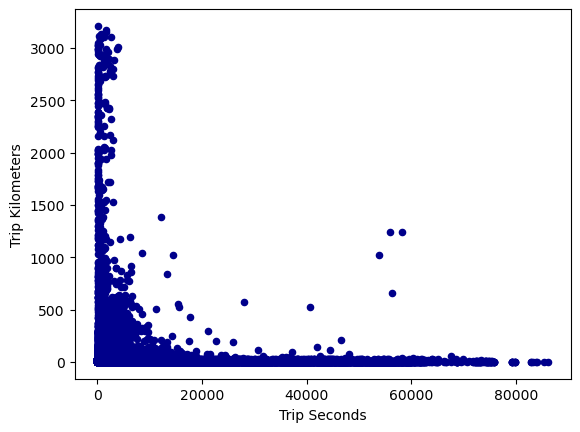

In [8]:
# Draw scatterplot
ax1 = df_trips.plot.scatter(x='Trip Seconds',
                      y='Trip Kilometers',
                      c='DarkBlue')

We can see that there is a number of trips with a high trip duration and/or high trip distance. In some cases, the respective ratio is also very unlikely to happen in the real world (e.g. 200 kilometers in less than 3600 seconds = 1 hour or only very few kilometers in more than 10800 seconds = 3 hours). 
<br> <br>
Moreover, even some of these outliers were real, they would occur only very seldomly in the real world. Therefore, we exclude trips with extreme durations or distances.

In [9]:
# Show minimum quantiles
df_trips['Trip Seconds'].quantile([.0,.01,.02,.03,.04,.05,0.1])

0.00      1.0
0.01    120.0
0.02    120.0
0.03    176.0
0.04    180.0
0.05    180.0
0.10    240.0
Name: Trip Seconds, dtype: float64

In [10]:
# Show maximum quantiles
df_trips['Trip Seconds'].quantile([.9,.95,.96,.97,.98,.99,1])

0.90     1440.0
0.95     2040.0
0.96     2220.0
0.97     2460.0
0.98     2820.0
0.99     3420.0
1.00    86220.0
Name: Trip Seconds, dtype: float64

When looking at the quantiles for the trip duration, cutoff values at 120 seconds (= 2 minutes) and 3600 seconds (= 60 minutes) appear to be reasonable. These values roughly correspond to the 1 % and the 99 % quantiles, and trips that are shorter than 2 minutes or longer than 1 hour can be consideres outliers or at least very unusual.

In [11]:
# Remove trips
df_trips = df_trips[(df_trips[['Trip Seconds']] >= 120).all(axis=1)]
df_trips = df_trips[(df_trips[['Trip Seconds']] <= 3600).all(axis=1)]


In [12]:
# Show minimum quantiles
df_trips['Trip Kilometers'].quantile([.0,.01,.02,.03,.04,.05,0.1])

0.00    0.016093
0.01    0.128748
0.02    0.160934
0.03    0.160934
0.04    0.160934
0.05    0.160934
0.10    0.225308
Name: Trip Kilometers, dtype: float64

In [13]:
# Show maximum quantiles
df_trips['Trip Kilometers'].quantile([.9,.95,.96,.97,.98,.99,1])

0.90      12.070080
0.95      27.680717
0.96      28.324454
0.97      28.807258
0.98      29.290061
0.99      33.635290
1.00    3170.407680
Name: Trip Kilometers, dtype: float64

When looking at the quantiles for the trip distance, cutoff values at 0.1 kilometers (= 100 meters) and 50 kilometers appear to be reasonable. The first value roughly corresponds to the 1 % quantile, whereas the second value is a higher than the 99 % quantile, but due to the city's maximum extent from north to south being around 40 kilometers air distance (https://www.britannica.com/place/Chicago), all trips within city limits should be realizable with 50 kilometers driving distance.

In [14]:
# Remove trips
df_trips = df_trips[(df_trips[['Trip Kilometers']] >= 0.1).all(axis=1)]
df_trips = df_trips[(df_trips[['Trip Kilometers']] <= 50).all(axis=1)]

We also remove trips that have identical pickup and dropoff locations, i.e. perfect round trips. Round trips are very unlikely because the coordinates are very precise and ending a trip at the exact same location becomes basically impossible.

In [15]:
# Function to check if values in a row are identical
def check_identical(row):
    return row['Pickup Centroid Location'] != row['Dropoff Centroid  Location']

# Boolean mask to identify rows with identical values in each row
mask = df_trips.apply(check_identical, axis=1)

# Filter the dataframe 
df_trips = df_trips[mask]

Now, we carry out the aforementioned conversion to datetime.

In [16]:
# Convert to datetime format
df_trips['Trip Start Timestamp'] = pd.to_datetime(df_trips['Trip Start Timestamp'])
df_trips['Trip End Timestamp'] = pd.to_datetime(df_trips['Trip End Timestamp'])


In [17]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8449592 entries, 4 to 15511064
Data columns (total 21 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip ID                     object        
 1   Taxi ID                     object        
 2   Trip Start Timestamp        datetime64[ns]
 3   Trip End Timestamp          datetime64[ns]
 4   Trip Seconds                float64       
 5   Trip Kilometers             float64       
 6   Pickup Census Tract         int64         
 7   Dropoff Census Tract        int64         
 8   Fare                        float64       
 9   Tips                        float64       
 10  Tolls                       float64       
 11  Extras                      float64       
 12  Trip Total                  float64       
 13  Payment Type                object        
 14  Company                     object        
 15  Pickup Centroid Latitude    float64       
 16  Pickup Centroid Longit

Since we have the correct format, we remove all trips that did not start in 2013, just be sure.

In [18]:
# Drop trips outside of 2013
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2014, 1, 1)
df_trips = df_trips[df_trips['Trip Start Timestamp'] >= d1]
df_trips = df_trips[df_trips['Trip Start Timestamp'] < d2]

Next, we sort the dataset by Trip Start Timestamp and update the indexes.

In [19]:
# Sort values
df_trips = df_trips.sort_values('Trip Start Timestamp', ascending=True)

# Update index
df_trips.reset_index(drop=True, inplace=True)

df_trips

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Kilometers,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,10508745a1069e9cdaad8760a6a243dc924cc0f2,e5c165fcc578673a02367d8d379846b48b00fbacf7f1b4...,2013-01-01 00:00:00,2013-01-01 00:15:00,480.0,8.851392,17031081403,17031031501,13.25,0.0,...,0.0,13.25,Cash,NaN,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.967289,-87.652435,POINT (-87.65243499970002 41.9672886138)
1,83f98ef1c4649f384143d0afbaca61124a55c56d,df713d3e792da0c30d1362aab25c15def59a179a6f4115...,2013-01-01 00:00:00,2013-01-01 00:15:00,780.0,40.233600,17031081000,17031070200,9.65,0.0,...,2.0,11.65,Cash,Taxi Affiliation Services,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.929078,-87.646293,POINT (-87.6462934762 41.9290776551)
2,ec9b946cec1a60e1e92770f9fd4679d11075bca8,82c4ec46427ecb85d3d46982e0c62cea7c6b90a3432b96...,2013-01-01 00:00:00,2013-01-01 00:15:00,480.0,37.014912,17031062200,17031830700,8.05,0.0,...,2.0,10.05,Cash,Taxi Affiliation Services,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),41.958056,-87.660389,POINT (-87.66038945570001 41.958055933)
3,6d041f951ccf8d799e676ddc4d387bc65efb2484,b1b569038610549b618e4fe62e3379b25606f7a3fc6f30...,2013-01-01 00:00:00,2013-01-01 00:15:00,600.0,7.081114,17031062100,17031081500,11.45,0.0,...,2.0,13.45,Cash,NaN,41.942692,-87.651771,POINT (-87.6517705068 41.9426918444),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
4,33a2a8383c24c41ea82634a1aabc550c2e6a5e73,d27db97dad3d4262c013e60d275eb210f8434265fc7d2d...,2013-01-01 00:00:00,2013-01-01 00:15:00,720.0,1.287475,17031081800,17031081600,7.65,0.0,...,3.0,10.65,Cash,Dispatch Taxi Affiliation,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8449587,24776474f25efd0a7b63a248f4d64bebedd884aa,07009b8e9b32f36656567f7809b970af38e59dbb58704a...,2013-12-31 23:45:00,2013-12-31 23:45:00,416.0,1.931213,17031081500,17031839100,6.25,0.0,...,2.0,8.25,Cash,Flash Cab,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
8449588,8e88ced92be1b1941cc34556db38f39c0a1de70c,35057a271731c5b976bda25efe85aa0c1901d0a5fc9ba2...,2013-12-31 23:45:00,2014-01-01 00:15:00,2460.0,10.943539,17031081500,17031031200,21.65,0.0,...,0.0,21.65,Cash,NaN,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.972710,-87.657341,POINT (-87.6573411073 41.9727095466)
8449589,465f98cf0c2999184aa19040b3b324dd1bdbeb9e,40f4cad7533b5bad8372636476a1d4a1e2bd7b8a47e6ca...,2013-12-31 23:45:00,2013-12-31 23:45:00,300.0,1.448410,17031081800,17031081500,5.25,0.0,...,1.0,6.25,Cash,KOAM Taxi Association,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
8449590,0524b962dbcb18352ee3a2cda36faead14872b14,5338c9353dcc39794670b869abb72d264d74450715ae57...,2013-12-31 23:45:00,2013-12-31 23:45:00,240.0,0.643738,17031081100,17031081600,4.45,0.0,...,2.5,6.95,Cash,NaN,41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347)


## H3-Uber

To be able to analyze the data in a spatial way, we discretize the city using h3-Uber (https://h3geo.org/docs/).
First, we take a look at the city using different hexagon resolutions.

<Axes: >

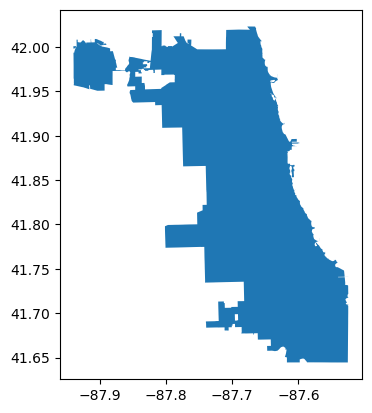

In [20]:
# Load Chicago's city boundaries and prepare dataset
city = gpd.read_file('boundaries_city.geojson')
city_json_string = city.to_json()
city_json = json.loads(city_json_string)
city_poly = city_json["features"][0]
city.plot()

Now, we look at different hexagon resolutions, starting with 7:

<Axes: >

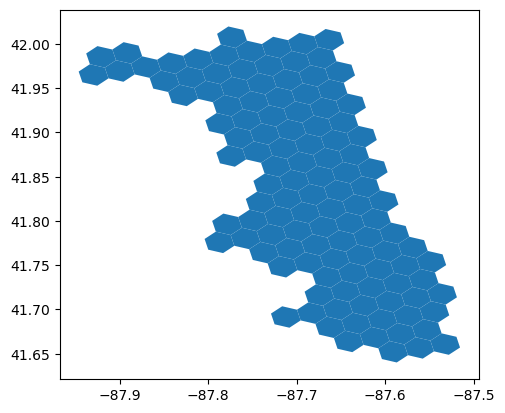

In [21]:
# Compute hexagons for city
# We have to iterate over all polygons in the multipolygon that is the city of Chicago
H3_HEXAGON_RESOLUTION = 7
multipolygon_obj = city_poly["geometry"]  
hexagons = []

# Iterate over each polygon within the multipolygon
for polygon_obj in multipolygon_obj["coordinates"]:
    # Create a GeoJSON dictionary with the polygon coordinates
    geojson = {
        "type": "Polygon",
        "coordinates": [polygon_obj[0]] 
    }

    # Perform polyfill operation on the individual polygon
    hexagons.extend(h3.polyfill(geojson, res=H3_HEXAGON_RESOLUTION, geo_json_conformant=True))
    
    
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df_hex = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])

df_hex['geometry'] = df_hex[(df_hex['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
df_hex.plot()

In [22]:
df_hex

,h3_hex_id,geometry
0,872664c81ffffff,"POLYGON ((-87.74870 41.89000, -87.76140 41.881..."
1,87266452cffffff,"POLYGON ((-87.74113 41.77636, -87.75380 41.768..."
2,872664cf4ffffff,"POLYGON ((-87.64775 41.86673, -87.66047 41.858..."
3,872664c8bffffff,"POLYGON ((-87.74491 41.83316, -87.75760 41.824..."
4,872664cc1ffffff,"POLYGON ((-87.60234 41.77784, -87.61504 41.769..."
...,...,...
113,872664cd6ffffff,"POLYGON ((-87.72399 41.81715, -87.73667 41.808..."
114,872664cd4ffffff,"POLYGON ((-87.69449 41.82154, -87.70718 41.813..."
115,87275936bffffff,"POLYGON ((-87.84509 41.99051, -87.85780 41.982..."
116,872664cd5ffffff,"POLYGON ((-87.67359 41.80552, -87.68628 41.797..."


We can see that the city is divided into 118 hexagons with an edge length of around 1.4 kilometers (https://h3geo.org/docs/core-library/restable/). This appears to be suitable for our purposes. To receive different variations, we also include the resolutions 6 and 8. Resoltions that are smaller or greater than 6,7,8 either are too big or too small to be useful for deriving any implications.

With hexagon resolution 6:

<Axes: >

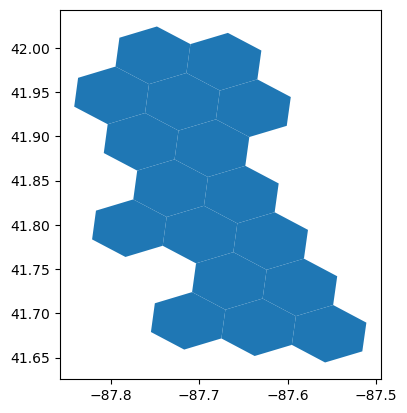

In [23]:
# Compute hexagons for city
# We have to iterate over all polygons in the multipolygon that is the city of Chicago
H3_HEXAGON_RESOLUTION = 6
multipolygon_obj = city_poly["geometry"]  
hexagons = []

# Iterate over each polygon within the multipolygon
for polygon_obj in multipolygon_obj["coordinates"]:
    # Create a GeoJSON dictionary with the polygon coordinates
    geojson = {
        "type": "Polygon",
        "coordinates": [polygon_obj[0]] 
    }

    # Perform polyfill operation on the individual polygon
    hexagons.extend(h3.polyfill(geojson, res=H3_HEXAGON_RESOLUTION, geo_json_conformant=True))
    
    
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df_hex = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])

df_hex['geometry'] = df_hex[(df_hex['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
df_hex.plot()

With hexagon resolution 8:

<Axes: >

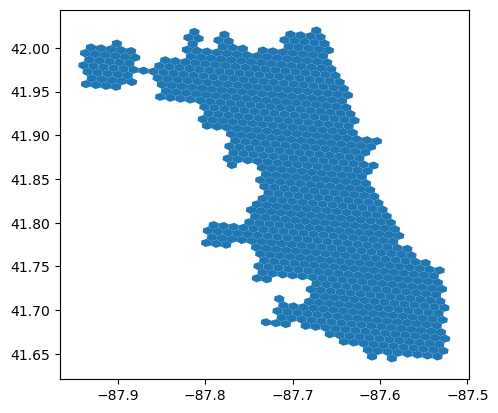

In [24]:
# Compute hexagons for city
# We have to iterate over all polygons in the multipolygon that is the city of Chicago
H3_HEXAGON_RESOLUTION = 8
multipolygon_obj = city_poly["geometry"]  
hexagons = []

# Iterate over each polygon within the multipolygon
for polygon_obj in multipolygon_obj["coordinates"]:
    # Create a GeoJSON dictionary with the polygon coordinates
    geojson = {
        "type": "Polygon",
        "coordinates": [polygon_obj[0]] 
    }

    # Perform polyfill operation on the individual polygon
    hexagons.extend(h3.polyfill(geojson, res=H3_HEXAGON_RESOLUTION, geo_json_conformant=True))
    
    
# Convert H3 Indexes to Geometry Objects

# Create geo data frame
df_hex = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])

df_hex['geometry'] = df_hex[(df_hex['h3_hex_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
df_hex.plot()

Having decided on the hexagon resolutions, we now add the corresponding hexagon cells for the different resolutions to each trip's start location.

In [25]:
# Add h3 index to dataframe
def get_h3_index(row, resolution):
   
    return h3.geo_to_h3(row['Pickup Centroid Latitude'], row['Pickup Centroid Longitude'], resolution)

# Apply the function to create new columns with the h3 index
df_trips['h3_hex_6'] = df_trips.apply(lambda row: get_h3_index(row, 6), axis=1)
df_trips['h3_hex_7'] = df_trips.apply(lambda row: get_h3_index(row, 7), axis=1)
df_trips['h3_hex_8'] = df_trips.apply(lambda row: get_h3_index(row, 8), axis=1)
df_trips

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Kilometers,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,...,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,h3_hex_6,h3_hex_7,h3_hex_8
0,10508745a1069e9cdaad8760a6a243dc924cc0f2,e5c165fcc578673a02367d8d379846b48b00fbacf7f1b4...,2013-01-01 00:00:00,2013-01-01 00:15:00,480.0,8.851392,17031081403,17031031501,13.25,0.0,...,NaN,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.967289,-87.652435,POINT (-87.65243499970002 41.9672886138),862664c1fffffff,872664c1effffff,882664c1e3fffff
1,83f98ef1c4649f384143d0afbaca61124a55c56d,df713d3e792da0c30d1362aab25c15def59a179a6f4115...,2013-01-01 00:00:00,2013-01-01 00:15:00,780.0,40.233600,17031081000,17031070200,9.65,0.0,...,Taxi Affiliation Services,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.929078,-87.646293,POINT (-87.6462934762 41.9290776551),862664c1fffffff,872664c1effffff,882664c1edfffff
2,ec9b946cec1a60e1e92770f9fd4679d11075bca8,82c4ec46427ecb85d3d46982e0c62cea7c6b90a3432b96...,2013-01-01 00:00:00,2013-01-01 00:15:00,480.0,37.014912,17031062200,17031830700,8.05,0.0,...,Taxi Affiliation Services,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),41.958056,-87.660389,POINT (-87.66038945570001 41.958055933),862664c17ffffff,872664c16ffffff,882664c163fffff
3,6d041f951ccf8d799e676ddc4d387bc65efb2484,b1b569038610549b618e4fe62e3379b25606f7a3fc6f30...,2013-01-01 00:00:00,2013-01-01 00:15:00,600.0,7.081114,17031062100,17031081500,11.45,0.0,...,NaN,41.942692,-87.651771,POINT (-87.6517705068 41.9426918444),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),862664c17ffffff,872664c16ffffff,882664c163fffff
4,33a2a8383c24c41ea82634a1aabc550c2e6a5e73,d27db97dad3d4262c013e60d275eb210f8434265fc7d2d...,2013-01-01 00:00:00,2013-01-01 00:15:00,720.0,1.287475,17031081800,17031081600,7.65,0.0,...,Dispatch Taxi Affiliation,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),862664c1fffffff,872664c1effffff,882664c1e5fffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8449587,24776474f25efd0a7b63a248f4d64bebedd884aa,07009b8e9b32f36656567f7809b970af38e59dbb58704a...,2013-12-31 23:45:00,2013-12-31 23:45:00,416.0,1.931213,17031081500,17031839100,6.25,0.0,...,Flash Cab,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),862664c1fffffff,872664c1effffff,882664c1e1fffff
8449588,8e88ced92be1b1941cc34556db38f39c0a1de70c,35057a271731c5b976bda25efe85aa0c1901d0a5fc9ba2...,2013-12-31 23:45:00,2014-01-01 00:15:00,2460.0,10.943539,17031081500,17031031200,21.65,0.0,...,NaN,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.972710,-87.657341,POINT (-87.6573411073 41.9727095466),862664c1fffffff,872664c1effffff,882664c1e1fffff
8449589,465f98cf0c2999184aa19040b3b324dd1bdbeb9e,40f4cad7533b5bad8372636476a1d4a1e2bd7b8a47e6ca...,2013-12-31 23:45:00,2013-12-31 23:45:00,300.0,1.448410,17031081800,17031081500,5.25,0.0,...,KOAM Taxi Association,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),862664c1fffffff,872664c1effffff,882664c1e5fffff
8449590,0524b962dbcb18352ee3a2cda36faead14872b14,5338c9353dcc39794670b869abb72d264d74450715ae57...,2013-12-31 23:45:00,2013-12-31 23:45:00,240.0,0.643738,17031081100,17031081600,4.45,0.0,...,NaN,41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),862664c1fffffff,872664c1effffff,882664c1edfffff


## Preparation

Finally, we rename the columns and rearrange them to facilitate usability as well as readability. 

In [26]:
# Rename columns
# Two spaces between Centroid and Location at Dropoff Centroid  Location
df_trips.rename(columns={"Trip ID": "trip_id", "Taxi ID": "taxi_id", "Trip Start Timestamp": "start_time", 
                         "Trip End Timestamp": "end_time", "Trip Seconds": "duration", "Trip Kilometers": "distance",
                         "Pickup Census Tract": "start_census_tract", "Dropoff Census Tract": "end_census_tract",
                         "Fare": "fare", "Extras": "extras", "Tips": "tips", "Tolls": "tolls", "Trip Total": "trip_total",
                         "Company": "company", "Payment Type": "payment_type", "Pickup Centroid Latitude": "start_lat",
                         "Pickup Centroid Longitude": "start_long", "Dropoff Centroid Latitude": "end_lat",
                         "Dropoff Centroid Longitude": "end_long",
                         "Pickup Centroid Location": "start_location", "Dropoff Centroid  Location": "end_location"}, inplace=True)

# Rearrange columns

cols = ['start_time', 'end_time', 'duration','distance','start_location','start_lat', 'start_long',
        'end_location', 'end_lat', 'end_long', 'start_census_tract', 'end_census_tract',
        'h3_hex_6', 'h3_hex_7', 'h3_hex_8', 'trip_id','taxi_id', 'company', 'payment_type', 
        'fare', 'extras', 'tips', 'tolls', 'trip_total']
df_trips = df_trips[cols]
df_trips


,start_time,end_time,duration,distance,start_location,start_lat,start_long,end_location,end_lat,end_long,...,h3_hex_8,trip_id,taxi_id,company,payment_type,fare,extras,tips,tolls,trip_total
0,2013-01-01 00:00:00,2013-01-01 00:15:00,480.0,8.851392,POINT (-87.6188683546 41.8909220259),41.890922,-87.618868,POINT (-87.65243499970002 41.9672886138),41.967289,-87.652435,...,882664c1e3fffff,10508745a1069e9cdaad8760a6a243dc924cc0f2,e5c165fcc578673a02367d8d379846b48b00fbacf7f1b4...,NaN,Cash,13.25,0.0,0.0,0.0,13.25
1,2013-01-01 00:00:00,2013-01-01 00:15:00,780.0,40.233600,POINT (-87.6321092196 41.9002656868),41.900266,-87.632109,POINT (-87.6462934762 41.9290776551),41.929078,-87.646293,...,882664c1edfffff,83f98ef1c4649f384143d0afbaca61124a55c56d,df713d3e792da0c30d1362aab25c15def59a179a6f4115...,Taxi Affiliation Services,Cash,9.65,2.0,0.0,0.0,11.65
2,2013-01-01 00:00:00,2013-01-01 00:15:00,480.0,37.014912,POINT (-87.6566440918 41.9425851797),41.942585,-87.656644,POINT (-87.66038945570001 41.958055933),41.958056,-87.660389,...,882664c163fffff,ec9b946cec1a60e1e92770f9fd4679d11075bca8,82c4ec46427ecb85d3d46982e0c62cea7c6b90a3432b96...,Taxi Affiliation Services,Cash,8.05,2.0,0.0,0.0,10.05
3,2013-01-01 00:00:00,2013-01-01 00:15:00,600.0,7.081114,POINT (-87.6517705068 41.9426918444),41.942692,-87.651771,POINT (-87.6262149064 41.8925077809),41.892508,-87.626215,...,882664c163fffff,6d041f951ccf8d799e676ddc4d387bc65efb2484,b1b569038610549b618e4fe62e3379b25606f7a3fc6f30...,NaN,Cash,11.45,2.0,0.0,0.0,13.45
4,2013-01-01 00:00:00,2013-01-01 00:15:00,720.0,1.287475,POINT (-87.6378442095 41.8932163595),41.893216,-87.637844,POINT (-87.6288741572 41.8920726347),41.892073,-87.628874,...,882664c1e5fffff,33a2a8383c24c41ea82634a1aabc550c2e6a5e73,d27db97dad3d4262c013e60d275eb210f8434265fc7d2d...,Dispatch Taxi Affiliation,Cash,7.65,3.0,0.0,0.0,10.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8449587,2013-12-31 23:45:00,2013-12-31 23:45:00,416.0,1.931213,POINT (-87.6262149064 41.8925077809),41.892508,-87.626215,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,...,882664c1e1fffff,24776474f25efd0a7b63a248f4d64bebedd884aa,07009b8e9b32f36656567f7809b970af38e59dbb58704a...,Flash Cab,Cash,6.25,2.0,0.0,NaN,8.25
8449588,2013-12-31 23:45:00,2014-01-01 00:15:00,2460.0,10.943539,POINT (-87.6262149064 41.8925077809),41.892508,-87.626215,POINT (-87.6573411073 41.9727095466),41.972710,-87.657341,...,882664c1e1fffff,8e88ced92be1b1941cc34556db38f39c0a1de70c,35057a271731c5b976bda25efe85aa0c1901d0a5fc9ba2...,NaN,Cash,21.65,0.0,0.0,0.0,21.65
8449589,2013-12-31 23:45:00,2013-12-31 23:45:00,300.0,1.448410,POINT (-87.6378442095 41.8932163595),41.893216,-87.637844,POINT (-87.6262149064 41.8925077809),41.892508,-87.626215,...,882664c1e5fffff,465f98cf0c2999184aa19040b3b324dd1bdbeb9e,40f4cad7533b5bad8372636476a1d4a1e2bd7b8a47e6ca...,KOAM Taxi Association,Cash,5.25,1.0,0.0,0.0,6.25
8449590,2013-12-31 23:45:00,2013-12-31 23:45:00,240.0,0.643738,POINT (-87.6291051864 41.9002212967),41.900221,-87.629105,POINT (-87.6288741572 41.8920726347),41.892073,-87.628874,...,882664c1edfffff,0524b962dbcb18352ee3a2cda36faead14872b14,5338c9353dcc39794670b869abb72d264d74450715ae57...,NaN,Cash,4.45,2.5,0.0,0.0,6.95


We use pickle to store the dataframe.

In [27]:
# Save as pickle
pickle.dump(df_trips, open("trips_2013.pkl","wb"))

# Weather Dataset

We build our weather dataset using the datasets from https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

## Cleaning Kaggle (OpenWeather) Datasets 


The data was originally procured from https://openweathermap.org/ 

Overview of the units for the city of Chicago:
https://openweathermap.org/city/4887398

### Temperature

Originally, the temperature is given in degree Kelvin.

In [28]:
# Load data
df_temp = pd.read_csv("temperature.csv", parse_dates=['datetime'])
df_temp.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


The procedure is more or less the same for all Kaggle datasets: 
* Remove all cities expect for Chicago
* Remove data that is not from the year 2013
* Add a unique index
* Rename the column "Chicago" to the respective type of weather data 

In [29]:
# Drop superfluous cities
df_temp.drop(df_temp.columns.difference(['datetime','Chicago']), axis=1, inplace=True)

# Drop superfluous weather data
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2014, 1, 1)
df_temp = df_temp[df_temp.datetime >= d1]
df_temp = df_temp[df_temp.datetime < d2]

# Add unique index to weather
df_temp.reset_index(drop=True, inplace=True)

# Rename column Chicago
df_temp.rename(columns={"Chicago": "temperature"}, inplace = True)

# Convert from Kelvin to Celsius
df_temp['temperature'] = df_temp['temperature'] - 273.15 
df_temp

,datetime,temperature
0,2013-01-01 00:00:00,-0.19
1,2013-01-01 01:00:00,0.28
2,2013-01-01 02:00:00,0.33
3,2013-01-01 03:00:00,0.12
4,2013-01-01 04:00:00,0.04
...,...,...
8755,2013-12-31 19:00:00,-11.27
8756,2013-12-31 20:00:00,-10.60
8757,2013-12-31 21:00:00,-10.98
8758,2013-12-31 22:00:00,-11.24


In [30]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     8760 non-null   datetime64[ns]
 1   temperature  8758 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


We can see that there are two temperature values missing.

In [31]:
df_temp.describe()

,datetime,temperature
count,8760,8758.000000
mean,2013-07-02 11:30:00,9.942069
min,2013-01-01 00:00:00,-17.920000
25%,2013-04-02 05:45:00,0.800000
50%,2013-07-02 11:30:00,10.364167
75%,2013-10-01 17:15:00,19.423000
max,2013-12-31 23:00:00,35.330000
std,NaN,11.210484


The temperatures seem to be consistent with what can be found about the weather (extremes) in Chicago: https://www.weather.gov/lot/Chicago_Temperature_Records

In [32]:
# Show Null values
df_temp[df_temp['temperature'].isna()]

,datetime,temperature
1663,2013-03-11 07:00:00,NaN
1664,2013-03-11 08:00:00,NaN


Coincidentally, the missing values are adjacent. Therefore, we have a look at the temperature before and after those missing values:

In [33]:
# Print values before and after missing values
print(df_temp[df_temp['datetime']=='2013-03-11 06:00:00'])
print(df_temp[df_temp['datetime']=='2013-03-11 09:00:00'])

                datetime  temperature
1662 2013-03-11 06:00:00         7.54
                datetime  temperature
1665 2013-03-11 09:00:00          5.7


In [34]:
# Fill missing values with average of values that are before and after missing ones
fill = (7.54 + 5.7) / 2
df_temp.at[1663,'temperature']= fill
df_temp.at[1664,'temperature']= fill
print(df_temp[df_temp['datetime']=='2013-03-11 07:00:00'])
print(df_temp[df_temp['datetime']=='2013-03-11 08:00:00'])

                datetime  temperature
1663 2013-03-11 07:00:00         6.62
                datetime  temperature
1664 2013-03-11 08:00:00         6.62


In [35]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     8760 non-null   datetime64[ns]
 1   temperature  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


In [36]:
df_temp.duplicated(keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool

There are no Null values or duplicates left.

In [37]:
df_temp.head()

,datetime,temperature
0,2013-01-01 00:00:00,-0.19
1,2013-01-01 01:00:00,0.28
2,2013-01-01 02:00:00,0.33
3,2013-01-01 03:00:00,0.12
4,2013-01-01 04:00:00,0.04


### Weather Description

We continue with the weather description.

In [38]:
# Load data
df_desc = pd.read_csv("weather_description.csv", parse_dates=['datetime'])
df_desc.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
1,2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear,mist,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2,2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
3,2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
4,2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


We proceed analogously to before:

In [39]:
# Drop superfluous cities
df_desc.drop(df_desc.columns.difference(['datetime','Chicago']), axis=1, inplace=True)

# Drop superfluous weather data
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2014, 1, 1)
df_desc = df_desc[df_desc.datetime >= d1]
df_desc = df_desc[df_desc.datetime < d2]

# Add unique index to weather
df_desc.reset_index(drop=True, inplace=True)


# Rename column Chicago
df_desc.rename(columns={"Chicago": "weather_description"}, inplace = True)
df_desc

,datetime,weather_description
0,2013-01-01 00:00:00,overcast clouds
1,2013-01-01 01:00:00,broken clouds
2,2013-01-01 02:00:00,overcast clouds
3,2013-01-01 03:00:00,overcast clouds
4,2013-01-01 04:00:00,broken clouds
...,...,...
8755,2013-12-31 19:00:00,broken clouds
8756,2013-12-31 20:00:00,broken clouds
8757,2013-12-31 21:00:00,light snow
8758,2013-12-31 22:00:00,snow


We can see that the weather is described with words, but we need numerical values for our tasks. Let us have a look at the frequency of different weather descriptions.

In [40]:
df_desc['weather_description'].value_counts()

weather_description
sky is clear                    2139
broken clouds                   1908
overcast clouds                 1329
scattered clouds                 902
few clouds                       639
light rain                       625
mist                             572
moderate rain                    170
heavy snow                       142
haze                              72
light snow                        59
heavy intensity rain              57
fog                               33
thunderstorm with light rain      22
light intensity drizzle           19
proximity thunderstorm            18
very heavy rain                   13
thunderstorm                      13
thunderstorm with rain             9
snow                               7
thunderstorm with heavy rain       5
drizzle                            4
light rain and snow                2
heavy intensity drizzle            1
Name: count, dtype: int64

In [41]:
df_desc.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             8760 non-null   datetime64[ns]
 1   weather_description  8760 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 137.0+ KB


In [42]:
df_desc.duplicated(keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool

There are no Null values or duplicates.

In [43]:
print(df_desc['weather_description'].unique())

['overcast clouds' 'broken clouds' 'sky is clear' 'scattered clouds'
 'few clouds' 'heavy snow' 'haze' 'mist' 'light rain'
 'light rain and snow' 'moderate rain' 'heavy intensity rain'
 'light intensity drizzle' 'fog' 'snow' 'light snow'
 'thunderstorm with rain' 'thunderstorm with light rain' 'drizzle'
 'proximity thunderstorm' 'thunderstorm with heavy rain' 'very heavy rain'
 'thunderstorm' 'heavy intensity drizzle']


We can see that there is a great variety of different weather descriptions. To quantify the descriptions, we reduce them to precipitation or no precipitation.

In [44]:
# Distinguish between precipitation and no precipitation (we consider proximity thunderstorm as precipitation)

df_desc.loc[(df_desc['weather_description'] == 'scattered clouds')
            |(df_desc['weather_description'] == 'sky is clear')
            |(df_desc['weather_description'] == 'overcast clouds')
            |(df_desc['weather_description'] == 'broken clouds')
            |(df_desc['weather_description'] == 'few clouds')
            |(df_desc['weather_description'] == 'fog')
            |(df_desc['weather_description'] == 'mist')
            |(df_desc['weather_description'] == 'haze'), 'weather_description'] = 0
df_desc.loc[(df_desc['weather_description'] != 0), 'weather_description'] = 1
df_desc

,datetime,weather_description
0,2013-01-01 00:00:00,0
1,2013-01-01 01:00:00,0
2,2013-01-01 02:00:00,0
3,2013-01-01 03:00:00,0
4,2013-01-01 04:00:00,0
...,...,...
8755,2013-12-31 19:00:00,0
8756,2013-12-31 20:00:00,0
8757,2013-12-31 21:00:00,1
8758,2013-12-31 22:00:00,1


1 means precipitation, 0 means no precipitation.

In [45]:
# Rename column weather_description to precip(itation)
df_desc.rename(columns={"weather_description": "precip"}, inplace = True)
df_desc.nunique()

datetime    8760
precip         2
dtype: int64

In [46]:
# Count number of hours with precipitation
df_desc['precip'].value_counts()

precip
0    7594
1    1166
Name: count, dtype: int64

In [47]:
df_desc.head()

,datetime,precip
0,2013-01-01 00:00:00,0
1,2013-01-01 01:00:00,0
2,2013-01-01 02:00:00,0
3,2013-01-01 03:00:00,0
4,2013-01-01 04:00:00,0


### Humidity

The humidity is given in percent.

In [48]:
# Load data
df_humid = pd.read_csv("humidity.csv", parse_dates=['datetime'])
df_humid.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0


We proceed analogously to before:

In [49]:
# Drop superfluous cities
df_humid.drop(df_humid.columns.difference(['datetime','Chicago']), axis=1, inplace=True)

# Drop superfluous weather data
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2014, 1, 1)
df_humid = df_humid[df_humid.datetime >= d1]
df_humid = df_humid[df_humid.datetime < d2]

# Add unique index to weather
df_humid.reset_index(drop=True, inplace=True)


# Rename column Chicago
df_humid.rename(columns={"Chicago": "humidity"}, inplace = True)
df_humid

,datetime,humidity
0,2013-01-01 00:00:00,NaN
1,2013-01-01 01:00:00,64.0
2,2013-01-01 02:00:00,69.0
3,2013-01-01 03:00:00,NaN
4,2013-01-01 04:00:00,68.0
...,...,...
8755,2013-12-31 19:00:00,89.0
8756,2013-12-31 20:00:00,89.0
8757,2013-12-31 21:00:00,89.0
8758,2013-12-31 22:00:00,89.0


In [50]:
df_humid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8760 non-null   datetime64[ns]
 1   humidity  8132 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


In [51]:
df_humid.duplicated(keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool

There are no duplicates, but there are around 600 Null rows with values (only 8132 non-null).

In [52]:
df_humid[df_humid['humidity'].isna()]

,datetime,humidity
0,2013-01-01 00:00:00,NaN
3,2013-01-01 03:00:00,NaN
6,2013-01-01 06:00:00,NaN
8,2013-01-01 08:00:00,NaN
9,2013-01-01 09:00:00,NaN
...,...,...
3725,2013-06-05 05:00:00,NaN
3727,2013-06-05 07:00:00,NaN
3729,2013-06-05 09:00:00,NaN
3730,2013-06-05 10:00:00,NaN


In [53]:
df_humid['humidity'].describe()

count    8132.000000
mean       75.193925
std        16.704538
min        17.000000
25%        64.000000
50%        78.000000
75%        89.000000
max       100.000000
Name: humidity, dtype: float64

We carry out imputation using the overall mean humidity to replace the missing values.

In [54]:
df_humid = df_humid.fillna(df_humid['humidity'].mean())
df_humid.head()

,datetime,humidity
0,2013-01-01 00:00:00,75.193925
1,2013-01-01 01:00:00,64.000000
2,2013-01-01 02:00:00,69.000000
3,2013-01-01 03:00:00,75.193925
4,2013-01-01 04:00:00,68.000000


### Wind Speed

The wind speed is given in m/s (meters per second).

In [55]:
# Load data
df_wind = pd.read_csv("wind_speed.csv", parse_dates=['datetime'])
df_wind.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,4.0,7.0,4.0,3.0,1.0,0.0,8.0,2.0,2.0,2.0
2,2012-10-01 14:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,4.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0
3,2012-10-01 15:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,3.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0
4,2012-10-01 16:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,3.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0


We proceed analogously to before:

In [56]:
# Drop superfluous cities
df_wind.drop(df_wind.columns.difference(['datetime','Chicago']), axis= 1, inplace=True)

# Drop superfluous weather data
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2014, 1, 1)
df_wind = df_wind[df_wind.datetime >= d1]
df_wind = df_wind[df_wind.datetime < d2]

# Add unique index to weather
df_wind.reset_index(drop=True, inplace=True)

# Rename column Chicago
df_wind.rename(columns={"Chicago": "wind_speed"}, inplace = True)
df_wind

,datetime,wind_speed
0,2013-01-01 00:00:00,4.0
1,2013-01-01 01:00:00,3.0
2,2013-01-01 02:00:00,6.0
3,2013-01-01 03:00:00,7.0
4,2013-01-01 04:00:00,7.0
...,...,...
8755,2013-12-31 19:00:00,0.0
8756,2013-12-31 20:00:00,0.0
8757,2013-12-31 21:00:00,3.0
8758,2013-12-31 22:00:00,1.0


In [57]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    8760 non-null   datetime64[ns]
 1   wind_speed  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


In [58]:
df_wind.duplicated(keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool

There are no Null values or duplicates.

In [59]:
df_wind['wind_speed'].describe()

count    8760.000000
mean        3.066667
std         2.238570
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        18.000000
Name: wind_speed, dtype: float64

In [60]:
df_wind.head()

,datetime,wind_speed
0,2013-01-01 00:00:00,4.0
1,2013-01-01 01:00:00,3.0
2,2013-01-01 02:00:00,6.0
3,2013-01-01 03:00:00,7.0
4,2013-01-01 04:00:00,7.0


### Pressure

The pressure is given in hPa (hectopascal).

In [61]:
# Load data
df_press = pd.read_csv("pressure.csv", parse_dates=['datetime'])
df_press.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1011.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2,2012-10-01 14:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
3,2012-10-01 15:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
4,2012-10-01 16:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


We proceed analogously to before.

In [62]:
# Drop superfluous cities
df_press.drop(df_press.columns.difference(['datetime','Chicago']), axis=1, inplace=True)

# Drop superfluous weather data
d1 = datetime.datetime(2013, 1, 1)
d2 = datetime.datetime(2014, 1, 1)
df_press = df_press[df_press.datetime >= d1]
df_press = df_press[df_press.datetime < d2]

# Add unique index to weather
df_press.reset_index(drop=True, inplace=True)

# Rename column Chicago
df_press.rename(columns={"Chicago": "pressure"}, inplace = True)
df_press

,datetime,pressure
0,2013-01-01 00:00:00,1024.0
1,2013-01-01 01:00:00,1022.0
2,2013-01-01 02:00:00,1022.0
3,2013-01-01 03:00:00,1021.0
4,2013-01-01 04:00:00,1021.0
...,...,...
8755,2013-12-31 19:00:00,1026.0
8756,2013-12-31 20:00:00,1026.0
8757,2013-12-31 21:00:00,1026.0
8758,2013-12-31 22:00:00,1026.0


In [63]:
df_press.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8760 non-null   datetime64[ns]
 1   pressure  8203 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


In [64]:
df_press.duplicated(keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool

Here, we once again have Null values, but no duplicates.

In [65]:
df_press[df_press['pressure'].isna()]

,datetime,pressure
6,2013-01-01 06:00:00,NaN
71,2013-01-03 23:00:00,NaN
107,2013-01-05 11:00:00,NaN
108,2013-01-05 12:00:00,NaN
143,2013-01-06 23:00:00,NaN
...,...,...
3722,2013-06-05 02:00:00,NaN
3725,2013-06-05 05:00:00,NaN
3727,2013-06-05 07:00:00,NaN
3729,2013-06-05 09:00:00,NaN


In [66]:
df_press['pressure'].describe()

count    8203.000000
mean     1016.571864
std         8.615725
min       979.000000
25%      1011.000000
50%      1016.000000
75%      1022.000000
max      1047.000000
Name: pressure, dtype: float64

We carry out imputation using the overall mean pressure to replace the missing values.

In [67]:
df_press = df_press.fillna(df_press['pressure'].mean())
# Show first 7 values because #6 was filled with mean
df_press.head(7) 

,datetime,pressure
0,2013-01-01 00:00:00,1024.000000
1,2013-01-01 01:00:00,1022.000000
2,2013-01-01 02:00:00,1022.000000
3,2013-01-01 03:00:00,1021.000000
4,2013-01-01 04:00:00,1021.000000
5,2013-01-01 05:00:00,1020.000000
6,2013-01-01 06:00:00,1016.571864


## Merging Kaggle Data

Now, we merge all the aforementioned dataframes using the datetime column.

In [68]:
# Merge on datetime
df_hourly = df_desc.merge(df_temp, left_on='datetime', right_on='datetime')
df_hourly = df_hourly.merge(df_humid, left_on='datetime', right_on='datetime')
df_hourly = df_hourly.merge(df_wind, left_on='datetime', right_on='datetime')
df_hourly = df_hourly.merge(df_press, left_on='datetime', right_on='datetime')
df_hourly.head()

,datetime,precip,temperature,humidity,wind_speed,pressure
0,2013-01-01 00:00:00,0,-0.19,75.193925,4.0,1024.0
1,2013-01-01 01:00:00,0,0.28,64.000000,3.0,1022.0
2,2013-01-01 02:00:00,0,0.33,69.000000,6.0,1022.0
3,2013-01-01 03:00:00,0,0.12,75.193925,7.0,1021.0
4,2013-01-01 04:00:00,0,0.04,68.000000,7.0,1021.0


In [69]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     8760 non-null   datetime64[ns]
 1   precip       8760 non-null   object        
 2   temperature  8760 non-null   float64       
 3   humidity     8760 non-null   float64       
 4   wind_speed   8760 non-null   float64       
 5   pressure     8760 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 410.8+ KB


In [70]:
df_hourly.describe()

,datetime,temperature,humidity,wind_speed,pressure
count,8760,8760.000000,8760.000000,8760.000000,8760.000000
mean,2013-07-02 11:30:00,9.941311,75.193925,3.066667,1016.571864
min,2013-01-01 00:00:00,-17.920000,17.000000,0.000000,979.000000
25%,2013-04-02 05:45:00,0.800000,65.000000,1.000000,1011.000000
50%,2013-07-02 11:30:00,10.361000,76.000000,3.000000,1016.571864
75%,2013-10-01 17:15:00,19.423000,89.000000,4.000000,1021.000000
max,2013-12-31 23:00:00,35.330000,100.000000,18.000000,1047.000000
std,NaN,11.209317,16.094563,2.238570,8.337281


There appears to be no problem with that dataframe, so we save it as a pickle.

In [71]:
# Save as pickle
pickle.dump(df_hourly, open("weather_hourly.pkl","wb"))

## Creating Additional Weather Datasets

Since we require different temporal intervals for our task, we now create additional weather datasets using the merged hourly data. First, we create a 4-hourly dataset.

### 4-Hourly

In [72]:
# Create duplicate
df_duplicated = df_hourly.copy()

# Set the 'datetime' column as the index
df_duplicated.set_index('datetime', inplace=True)

# Resample the data into 4-hour intervals and calculate the average temperature
df_4hourly = df_duplicated.resample('4H').mean()

# Reset the index to make the 'datetime' column a regular column again
df_4hourly.reset_index(inplace=True)
df_4hourly

,datetime,precip,temperature,humidity,wind_speed,pressure
0,2013-01-01 00:00:00,0.0,0.13500,70.846963,5.00,1022.250000
1,2013-01-01 04:00:00,0.0,-0.03750,69.798481,5.25,1018.892966
2,2013-01-01 08:00:00,0.0,0.74000,70.846963,5.75,1017.500000
3,2013-01-01 12:00:00,0.0,1.37000,59.250000,5.50,1017.000000
4,2013-01-01 16:00:00,0.0,0.96750,61.500000,5.25,1017.000000
...,...,...,...,...,...,...
2185,2013-12-31 04:00:00,0.5,-12.73000,89.000000,0.50,1022.000000
2186,2013-12-31 08:00:00,0.0,-14.52000,86.500000,1.25,1024.000000
2187,2013-12-31 12:00:00,0.0,-15.36125,89.000000,1.75,1023.750000
2188,2013-12-31 16:00:00,0.25,-11.89225,90.250000,1.00,1028.250000


We want the precipitation to be either 0 or 1, therefore we need to round it to 0 or 1 (0.5 is 1). This means that precipitation during 2 of the 4 hours is interpreted as an interval with precipitation.

In [73]:
# Round the values in the column
df_4hourly['precip'] = df_4hourly['precip'].apply(lambda x: math.ceil(x) if x >= 0.5 else math.floor(x))
df_4hourly

,datetime,precip,temperature,humidity,wind_speed,pressure
0,2013-01-01 00:00:00,0,0.13500,70.846963,5.00,1022.250000
1,2013-01-01 04:00:00,0,-0.03750,69.798481,5.25,1018.892966
2,2013-01-01 08:00:00,0,0.74000,70.846963,5.75,1017.500000
3,2013-01-01 12:00:00,0,1.37000,59.250000,5.50,1017.000000
4,2013-01-01 16:00:00,0,0.96750,61.500000,5.25,1017.000000
...,...,...,...,...,...,...
2185,2013-12-31 04:00:00,1,-12.73000,89.000000,0.50,1022.000000
2186,2013-12-31 08:00:00,0,-14.52000,86.500000,1.25,1024.000000
2187,2013-12-31 12:00:00,0,-15.36125,89.000000,1.75,1023.750000
2188,2013-12-31 16:00:00,0,-11.89225,90.250000,1.00,1028.250000


In [74]:
df_4hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     2190 non-null   datetime64[ns]
 1   precip       2190 non-null   int64         
 2   temperature  2190 non-null   float64       
 3   humidity     2190 non-null   float64       
 4   wind_speed   2190 non-null   float64       
 5   pressure     2190 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 102.8 KB


In [75]:
df_4hourly.describe()

,datetime,precip,temperature,humidity,wind_speed,pressure
count,2190,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,2013-07-02 10:00:00,0.148402,9.941311,75.193925,3.066667,1016.571864
min,2013-01-01 00:00:00,0.000000,-17.527500,27.500000,0.000000,989.500000
25%,2013-04-02 05:00:00,0.000000,0.818750,65.500000,1.500000,1011.500000
50%,2013-07-02 10:00:00,0.000000,10.228625,76.000000,2.750000,1016.571864
75%,2013-10-01 15:00:00,0.000000,19.470297,87.750000,4.000000,1021.026949
max,2013-12-31 20:00:00,1.000000,34.316250,100.000000,12.500000,1045.250000
std,NaN,0.355579,11.136285,14.718522,1.994813,7.913293


In [76]:
df_4hourly['precip'].value_counts()

precip
0    1865
1     325
Name: count, dtype: int64

In [77]:
# Save as pickle
pickle.dump(df_4hourly, open("weather_4hourly.pkl","wb"))

### Daily

Now, we create a daily dataset.

In [78]:
# Create duplicate
df_duplicated = df_hourly.copy()

# Set the 'datetime' column as the index
df_duplicated.set_index('datetime', inplace=True)

# Resample the data into 4-hour intervals and calculate the average temperature
df_daily = df_duplicated.resample('1D').mean()

# Reset the index to make the 'datetime' column a regular column again
df_daily.reset_index(inplace=True)
df_daily

,datetime,precip,temperature,humidity,wind_speed,pressure
0,2013-01-01,0.0,0.324167,67.306562,5.083333,1018.190494
1,2013-01-02,0.041667,-6.267500,55.250000,3.416667,1020.708333
2,2013-01-03,0.0,-6.540833,57.341414,4.083333,1018.440494
3,2013-01-04,0.291667,-3.306667,67.125000,4.625000,1020.583333
4,2013-01-05,0.0,-4.232448,67.549747,5.708333,1024.214322
...,...,...,...,...,...,...
360,2013-12-27,0.291667,1.209167,89.000000,1.375000,1020.041667
361,2013-12-28,0.708333,4.933125,89.000000,1.958333,1015.750000
362,2013-12-29,0.208333,1.697500,88.833333,2.375000,1009.833333
363,2013-12-30,0.166667,-11.748333,87.083333,2.000000,1021.125000


Once more, we round to 0 or 1 (0.5 is 1). Thus, a day with 12 hours of precipitation is considered to be a day with precipitation.

In [79]:
# Round the values in the column
df_daily['precip'] = df_daily['precip'].apply(lambda x: math.ceil(x) if x >= 0.5 else math.floor(x))
df_daily

,datetime,precip,temperature,humidity,wind_speed,pressure
0,2013-01-01,0,0.324167,67.306562,5.083333,1018.190494
1,2013-01-02,0,-6.267500,55.250000,3.416667,1020.708333
2,2013-01-03,0,-6.540833,57.341414,4.083333,1018.440494
3,2013-01-04,0,-3.306667,67.125000,4.625000,1020.583333
4,2013-01-05,0,-4.232448,67.549747,5.708333,1024.214322
...,...,...,...,...,...,...
360,2013-12-27,0,1.209167,89.000000,1.375000,1020.041667
361,2013-12-28,1,4.933125,89.000000,1.958333,1015.750000
362,2013-12-29,0,1.697500,88.833333,2.375000,1009.833333
363,2013-12-30,0,-11.748333,87.083333,2.000000,1021.125000


In [80]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     365 non-null    datetime64[ns]
 1   precip       365 non-null    int64         
 2   temperature  365 non-null    float64       
 3   humidity     365 non-null    float64       
 4   wind_speed   365 non-null    float64       
 5   pressure     365 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 17.2 KB


In [81]:
df_daily.describe()

,datetime,precip,temperature,humidity,wind_speed,pressure
count,365,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2013-07-02 00:00:00,0.060274,9.941311,75.193925,3.066667,1016.571864
min,2013-01-01 00:00:00,0.000000,-14.945000,43.466414,0.291667,994.208333
25%,2013-04-02 00:00:00,0.000000,0.940500,67.871203,1.875000,1012.041667
50%,2013-07-02 00:00:00,0.000000,9.773514,75.056562,2.625000,1016.500000
75%,2013-10-01 00:00:00,0.000000,19.381469,84.474494,4.000000,1020.875000
max,2013-12-31 00:00:00,1.000000,30.166250,100.000000,10.250000,1040.750000
std,NaN,0.238320,10.720180,11.210224,1.642333,6.979278


In [82]:
df_daily['precip'].value_counts()

precip
0    343
1     22
Name: count, dtype: int64

In [83]:
# Save as pickle
pickle.dump(df_daily, open("weather_daily.pkl","wb"))